In [ ]:
!find ../../images-desi-lowz -type f -print0 | xargs -0 ls -l | awk '{size[int(log($5)/log(2))]++}END{for (i in size) printf("%10d %3d\n", 2^i, size[i])}' | sort -n

         0   7
      1024 160
      2048  30
      4096 228
      8192 228799
     16384 3532999
     32768 107

# Load learner

In [2]:
from fastai2.basics import *
from fastai2.vision.all import *
from pathlib import Path

from mish_cuda import MishCuda
import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tqdm.notebook as tqdm

seed = 256

%matplotlib inline

In [3]:
import sys
PATH = Path('../..').resolve()

sys.path.append(f'{PATH}/src')
from utils import *

learner_metrics = [accuracy, F1Score(), Recall(), Precision()]

sys.path.append('/home/jupyter/morphological-spectra/src')
from xresnet_deconv import *

In [4]:
# https://github.com/fastai/fastai/blob/master/fastai/losses.py#L48
class FocalLossFlat(CrossEntropyLossFlat):
    """
    Same as CrossEntropyLossFlat but with focal paramter, `gamma`. Focal loss is introduced by Lin et al.
    https://arxiv.org/pdf/1708.02002.pdf. Note the class weighting factor in the paper, alpha, can be
    implemented through pytorch `weight` argument in nn.CrossEntropyLoss.
    """
    y_int = True
    @use_kwargs_dict(keep=True, weight=None, ignore_index=-100, reduction='mean')
    def __init__(self, *args, gamma=2, axis=-1, **kwargs):
        self.gamma = gamma
        self.reduce = kwargs.pop('reduction') if 'reduction' in kwargs else 'mean'
        super().__init__(*args, reduction='none', axis=axis, **kwargs)
    def __call__(self, inp, targ, **kwargs):
        ce_loss = super().__call__(inp, targ, **kwargs)
        pt = torch.exp(-ce_loss)
        fl_loss = (1-pt)**self.gamma * ce_loss
        return fl_loss.mean() if self.reduce == 'mean' else fl_loss.sum() if self.reduce == 'sum' else fl_loss


In [5]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-19.csv', dtype={'OBJID': str})

df = saga.sample(frac=1, random_state=seed).copy()
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1


label_column = 'low_z'

# focal loss weight params
gamma = 2
loss_func = FocalLossFlat(gamma=gamma)

sz = 144
bs = 128

img_dir = 'images-legacy_saga-2021-02-19'

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(sz)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)

seed = 256  

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/images-legacy_saga-2021-02-19/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)

model = xresnet34_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=loss_func,
)
learn.load(f'{PATH}/models/desi-sv_FL-hdxresnet34-sz{sz}');

# Get all filenames

In [12]:
filenames = list(x for x in (PATH/'images-desi-lowz').rglob('*.jpg') if (x.stat().st_size > 0))
len(filenames)

3762323

# Make predictions for the north

In [14]:
dn = pd.read_csv(PATH/'data/desi_low_z_target_list_north_dr9.csv', index_col=0)
dn.shape

(774775, 147)

In [19]:
dn['objname'] = (dn.RA * 1000000).astype(int).astype(str) + (dn.DEC * 1000000).astype(int).astype(str)

In [22]:
north_filenames = dn.objname[dn.objname.isin([x.stem for x in filenames])].values
north_filenames.shape

(766869,)

In [27]:
dn = dn.set_index('objname').loc[north_filenames].reset_index()
dn.head()

,objname,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,...,z_mag,z_err,r_fib_mag,u_mag,u_err,i_mag,i_err,mu_r,mu_r_err,bgs
0,37019840-2734175,9011,314676,b'0371m027',125,b'EXP',37.019841,-2.734175,3.053340e+10,6.025484e+10,...,99.0,99.0,21.590014,99.0,99.0,99.0,99.0,23.157320,0.045834,False
1,37048051-2717422,9011,314676,b'0371m027',258,b'EXP',37.048051,-2.717423,1.077153e+10,1.555823e+10,...,99.0,99.0,22.160279,99.0,99.0,99.0,99.0,23.575838,0.043117,False
2,37131668-2695066,9011,314676,b'0371m027',700,b'REX',37.131669,-2.695066,5.821827e+09,6.403100e+09,...,99.0,99.0,22.571179,99.0,99.0,99.0,99.0,23.510659,0.043168,False
3,37148296-2697212,9011,314676,b'0371m027',779,b'EXP',37.148297,-2.697213,2.988050e+10,1.300981e+10,...,99.0,99.0,22.095843,99.0,99.0,99.0,99.0,23.652900,0.079657,False
4,37181168-2625361,9011,314676,b'0371m027',1046,b'REX',37.181169,-2.625362,4.709894e+09,4.872066e+09,...,99.0,99.0,22.656726,99.0,99.0,99.0,99.0,23.731185,0.072533,False


In [29]:
test_dl_north = dls.test_dl([f'{PATH}/images-desi-lowz/{x}.jpg' for x in north_filenames], num_workers=8, bs=32)

In [30]:
m = learn.model.eval()

outputs = []
with torch.no_grad():
    for (xb,) in tqdm.tqdm(iter(test_dl_north), total=len(test_dl_north)):
        outputs.append(m(xb).cpu())
        
outs = torch.cat(outputs)
ps = outs.softmax(1)


In [38]:
preds_north = pd.DataFrame({
    'objname': north_filenames,
    'p_CNN': ps[:, 1],
})

In [36]:
preds_north.to_csv(PATH/'results/desi-lowz/north_CNN-hdx34-sz144_2021-03-05.csv', index=False)

# Make predictions for the south

In [13]:
ds = pd.read_csv(PATH/'data/desi_low_z_target_list_south_dr9.csv', index_col=0)
ds.shape

/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2581389, 147)

In [31]:
ds['objname'] = (ds.RA * 1000000).astype(int).astype(str) + (ds.DEC * 1000000).astype(int).astype(str)

In [32]:
south_filenames = ds.objname[ds.objname.isin([x.stem for x in filenames])].values
south_filenames.shape

(2573899,)

In [33]:
ds = ds.set_index('objname').loc[south_filenames].reset_index()
ds.head()

,objname,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,...,z_mag,z_err,r_fib_mag,u_mag,u_err,i_mag,i_err,mu_r,mu_r_err,bgs
0,6261736-144057,9010,328953,b'0063m002',517,b'SER',6.261736,-0.144057,2.105924e+11,8.435161e+10,...,20.812557,0.034424,22.527137,99.0,99.0,99.0,99.0,24.487513,0.026135,False
1,6283237-160819,9010,328953,b'0063m002',1319,b'SER',6.283237,-0.160820,4.487618e+11,8.584823e+11,...,19.760152,0.012139,21.605339,99.0,99.0,99.0,99.0,23.717109,0.018577,False
2,6291097-245064,9010,328953,b'0063m002',1605,b'SER',6.291098,-0.245064,6.258617e+11,1.616603e+11,...,19.519844,0.012664,21.685894,99.0,99.0,99.0,99.0,23.620029,0.008111,True
3,6305571-153063,9010,328953,b'0063m002',2144,b'EXP',6.305571,-0.153063,1.100458e+11,5.687685e+10,...,20.444074,0.029822,22.531761,99.0,99.0,99.0,99.0,23.964948,0.021715,False
4,6340718-326017,9010,328953,b'0063m002',3483,b'SER',6.340718,-0.326017,1.510274e+11,6.378672e+10,...,20.650745,0.027399,22.413052,99.0,99.0,99.0,99.0,23.676133,0.009471,False


In [39]:
test_dl_south = dls.test_dl([f'{PATH}/images-desi-lowz/{x}.jpg' for x in south_filenames], num_workers=8, bs=32)

In [40]:
m = learn.model.eval()

outputs = []
with torch.no_grad():
    for (xb,) in tqdm.tqdm(iter(test_dl_south), total=len(test_dl_south)):
        outputs.append(m(xb).cpu())
        
outs = torch.cat(outputs)
ps = outs.softmax(1)

In [41]:
preds_south = pd.DataFrame({
    'objname': south_filenames,
    'p_CNN': ps[:, 1],
})

In [42]:
preds_south.to_csv(PATH/'results/desi-lowz/south_CNN-hdx34-sz144_2021-03-05.csv', index=False)

# Quick validation

In [46]:
preds_north = preds_north.reset_index().join(dn.set_index('objname'), on='objname', how='inner')
preds_north.shape

(766869, 150)

In [47]:
preds_south = preds_south.reset_index().join(ds.set_index('objname'), on='objname', how='inner')
preds_south.shape

(2573899, 150)

Text(0, 0.5, 'DEC')

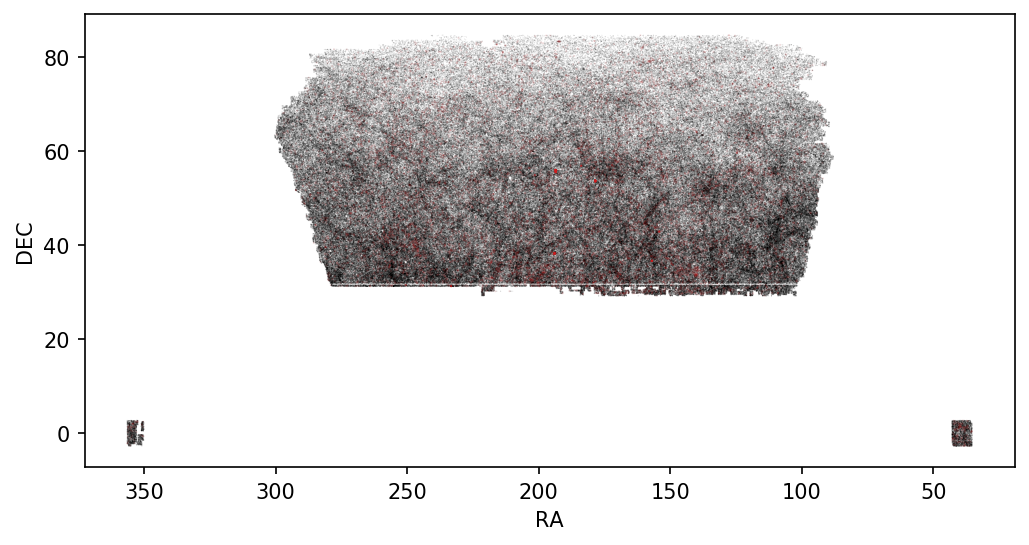

In [50]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(preds_north.RA, preds_north.DEC, s=0.3, color='k', edgecolor='none', alpha=0.1)
plt.scatter(preds_north[preds_north.p_CNN > 0.5].RA, preds_north[preds_north.p_CNN > 0.5].DEC, s=1, color='C3', edgecolor='none', alpha=0.1)

plt.xlim(*reversed(plt.xlim()))
plt.xlabel('RA')
plt.ylabel('DEC')

Text(0, 0.5, 'DEC')

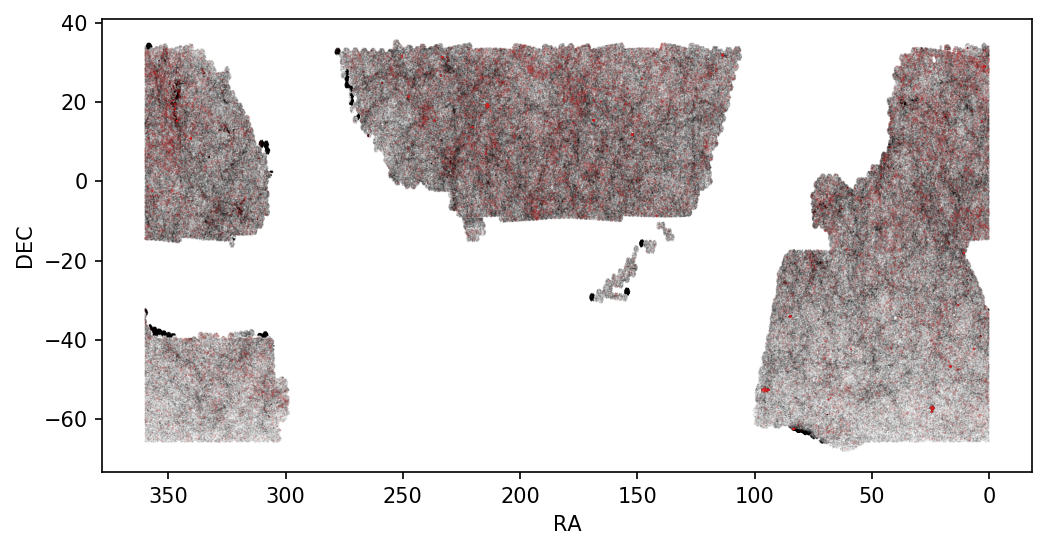

In [51]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(preds_south.RA, preds_south.DEC, s=0.3, color='k', edgecolor='none', alpha=0.03)
plt.scatter(preds_south[preds_south.p_CNN > 0.5].RA, preds_south[preds_south.p_CNN > 0.5].DEC, s=1, color='C3', edgecolor='none', alpha=0.1)

plt.xlim(*reversed(plt.xlim()))
plt.xlabel('RA')
plt.ylabel('DEC')

# Predicting 20 targets per square degree

According to Dey et al., the north is 5000 sq deg (BASS+MzLS) and the south is 9000 (DECaLS). At 20 per square degree, we want **100k** and **180k** respectively

In [58]:
for thresh in [0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2]:
    print(f'{thresh:.2f} | {sum(preds_north.p_CNN > thresh):> 7d} | {sum(preds_south.p_CNN > thresh):> 7d}')

0.70 |    1482 |    4919
0.60 |    5459 |   17264
0.50 |   15199 |   47412
0.40 |   34831 |  108904
0.30 |   69896 |  218847
0.25 |   97736 |  302757
0.20 |  139914 |  425198


Still, we can just take the top 100k and top 180k from the ranked list.

In [63]:
preds_north

,index,objname,p_CNN,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,...,z_mag,z_err,r_fib_mag,u_mag,u_err,i_mag,i_err,mu_r,mu_r_err,bgs
0,0,37019840-2734175,0.161989,9011,314676,b'0371m027',125,b'EXP',37.019841,-2.734175,...,99.000000,99.000000,21.590014,99.0,99.0,99.0,99.0,23.157320,0.045834,False
1,1,37048051-2717422,0.199659,9011,314676,b'0371m027',258,b'EXP',37.048051,-2.717423,...,99.000000,99.000000,22.160279,99.0,99.0,99.0,99.0,23.575838,0.043117,False
2,2,37131668-2695066,0.037406,9011,314676,b'0371m027',700,b'REX',37.131669,-2.695066,...,99.000000,99.000000,22.571179,99.0,99.0,99.0,99.0,23.510659,0.043168,False
3,3,37148296-2697212,0.063423,9011,314676,b'0371m027',779,b'EXP',37.148297,-2.697213,...,99.000000,99.000000,22.095843,99.0,99.0,99.0,99.0,23.652900,0.079657,False
4,4,37181168-2625361,0.093968,9011,314676,b'0371m027',1046,b'REX',37.181169,-2.625362,...,99.000000,99.000000,22.656726,99.0,99.0,99.0,99.0,23.731185,0.072533,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766864,766864,3510271411290094,0.060975,9011,338972,b'3511p012',324,b'EXP',351.027141,1.290094,...,19.501261,0.034525,21.681945,99.0,99.0,99.0,99.0,23.499400,0.045757,False
766865,766865,351000151492280,0.070385,9011,334652,b'3511p005',29,b'SER',351.000151,0.492281,...,19.229932,0.020937,21.430778,99.0,99.0,99.0,99.0,23.343949,0.024534,False
766866,766866,351018864542952,0.020658,9011,334652,b'3511p005',240,b'SER',351.018865,0.542953,...,18.866868,0.015206,21.012373,99.0,99.0,99.0,99.0,22.710455,0.018000,False
766867,766867,351018895528924,0.100453,9011,334652,b'3511p005',241,b'EXP',351.018895,0.528925,...,19.591189,0.032563,21.836182,99.0,99.0,99.0,99.0,23.969198,0.040836,False


In [64]:
preds_north.sort_values('p_CNN', ascending=False).head(100000).to_csv(PATH/'results/desi-lowz/north-CNN_preds.csv', index=False)
preds_south.sort_values('p_CNN', ascending=False).head(180000).to_csv(PATH/'results/desi-lowz/south-CNN_preds.csv', index=False)

In [65]:
dfn = pd.read_csv(PATH/'results/desi-lowz/north-CNN_preds.csv', index_col='objname')[['RA', 'DEC', 'p_CNN']]
dfn.head(20)

,RA,DEC,p_CNN
objname,,,
17492511231905593,174.925113,31.905594,0.982524
11636727375534135,116.367274,75.534136,0.919829
26680667044531039,266.806670,44.531039,0.900871
15694506736690981,156.945068,36.690982,0.895541
15698379636726984,156.983797,36.726985,0.894527
19761796434236162,197.617965,34.236162,0.888145
28468247872011198,284.682479,72.011199,0.885281
14130844958957059,141.308449,58.957059,0.878997
11637231275537788,116.372313,75.537788,0.875058


In [66]:
dfs = pd.read_csv(PATH/'results/desi-lowz/south-CNN_preds.csv', index_col='objname')[['RA', 'DEC', 'p_CNN']]
dfs.head(20)

,RA,DEC,p_CNN
objname,,,
21415144919145290,214.151449,19.145290,0.998264
21417971619082487,214.179716,19.082488,0.998151
21416076219130910,214.160762,19.130910,0.998110
21434910819140234,214.349108,19.140234,0.997951
21415167319137207,214.151674,19.137207,0.997884
21435037819165120,214.350379,19.165121,0.997648
21416312719121095,214.163127,19.121096,0.997634
21432874919117669,214.328750,19.117669,0.997393
21403349519478609,214.033496,19.478609,0.997096
